# Proyecto - Seminario de Sistemas 2 - Fase 2
# EDA Monovariable y Multivariable

## Lectura de Datos (SQL Server -> Pandas Dataframe) + Importaciones

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine


In [34]:
# Configuración de conexión a SQL Server
server = 'FROI-PC\\SQLEXPRESS'
database = 'covid-data'
trusted_connection = 'yes'

# Especificar el controlador de pyodbc en la cadena de conexión
conn_str = f'mssql+pyodbc://{server}/{database}?trusted_connection={trusted_connection}&driver=ODBC+Driver+17+for+SQL+Server'

# Crear el motor de SQLAlchemy
engine = create_engine(conn_str)

# Consulta SQL para extraer datos
sql_query_municipality = 'SELECT * FROM MUNICIPALITY'
sql_query_department = 'SELECT * FROM DEPARTMENT'
sql_query_municipality_deaths = 'SELECT MD.municipality_code, MD.date, MD.total_deaths, MD.day_deaths, M.name AS \'municipality_name\', D.name AS \'department_name\' FROM MUNICIPALITY_DEATHS AS MD LEFT JOIN MUNICIPALITY AS M ON MD.municipality_code=M.code LEFT JOIN DEPARTMENT AS D ON M.department_code=D.code'
sql_query_country_deaths = 'SELECT * FROM COUNTRY_DEATHS'
sql_query_department_population = 'SELECT D.[code] AS DepartmentCode, D.[name] AS DepartmentName, SUM(M.[population]) AS TotalPopulation FROM [dbo].[DEPARTMENT] D JOIN [dbo].[MUNICIPALITY] M ON D.[code] = M.[department_code] GROUP BY D.[code], D.[name] ORDER BY CONVERT(INT, D.[code]);'

# Ejecutar la consulta y cargar los resultados en DataFrames
df_municipality = pd.read_sql(sql_query_municipality, engine)
df_department = pd.read_sql(sql_query_department, engine)
df_municipality_deaths = pd.read_sql(sql_query_municipality_deaths, engine)
df_country_deaths = pd.read_sql(sql_query_country_deaths, engine)
df_department_population = pd.read_sql(sql_query_department_population, engine)

In [35]:
df_municipality.head(4)
df_municipality.tail(4)

,code,name,department_code,population
333,921,GENOVA,9,45162
334,922,FLORES COSTA CUCA,9,23851
335,923,LA ESPERANZA,9,24199
336,924,PALESTINA DE LOS ALTOS,9,20299


In [36]:
df_department.head(4)
df_department.tail(4)

,code,name
18,6,SANTA ROSA
19,7,SOLOLA
20,8,TOTONICAPAN
21,9,QUETZALTENANGO


In [37]:
df_municipality_deaths.head(4)
df_municipality_deaths.tail(4)

,municipality_code,date,total_deaths,day_deaths,municipality_name,department_name
85931,924,2020-12-28,0,138,PALESTINA DE LOS ALTOS,QUETZALTENANGO
85932,924,2020-12-29,0,132,PALESTINA DE LOS ALTOS,QUETZALTENANGO
85933,924,2020-12-30,0,846,PALESTINA DE LOS ALTOS,QUETZALTENANGO
85934,924,2020-12-31,0,879,PALESTINA DE LOS ALTOS,QUETZALTENANGO


In [38]:
df_country_deaths.head(4)
df_country_deaths.tail(4)

,date,country_code,new_cases,cumulative_cases,new_deaths,cumulative_deaths
357,2020-12-28,GT,138,135309,5,4768
358,2020-12-29,GT,132,135441,5,4773
359,2020-12-30,GT,846,136287,8,4781
360,2020-12-31,GT,879,137166,22,4803


In [39]:
df_country_deaths.dtypes

date                 datetime64[ns]
country_code                 object
new_cases                     int64
cumulative_cases              int64
new_deaths                    int64
cumulative_deaths             int64
dtype: object

## Transformaciones

In [40]:
# Se
# Asegurar que la columna 'date' sea de tipo datetime64[ns]
df_country_deaths['date'] = pd.to_datetime(df_country_deaths['date'])

# Filtrar registros directamente en el mismo DataFrame
df_country_deaths = df_country_deaths[df_country_deaths['date'] > '2020-03-15']

## EDA Monovariable

### Análisis de Nuevas Muertes

In [41]:
# Estadísticas Descriptivas
describe = df_country_deaths['new_deaths'].describe()
print(f"Estadísticas descriptivas\n{describe}\n")

# Estadísticas de Conteo
count = df_country_deaths['new_deaths'].count()
print(f"Estadísticas de Conteo\n{count}\n")

# Valores únicos
unique = df_country_deaths['new_deaths'].unique()
nunique = df_country_deaths['new_deaths'].nunique()
print(f"Valores Únicos\n{unique}")
print(f"Valores Únicos (cantidad): {nunique}\n")
# Promedio
mean = df_country_deaths['new_deaths'].mean()
print(f"Promedio\n{mean}\n")

# Cuartiles
# Mediana (50%)
median_new_deaths = df_country_deaths['new_deaths'].median()

# Cuartiles (25%, 75%)
q1_new_deaths = df_country_deaths['new_deaths'].quantile(0.25)
q3_new_deaths = df_country_deaths['new_deaths'].quantile(0.75)

print("\nMediana para 'new_deaths':", median_new_deaths)
print("\nCuartil 25% para 'new_deaths':", q1_new_deaths)
print("\nCuartil 75% para 'new_deaths':", q3_new_deaths)

Estadísticas descriptivas
count    288.000000
mean      16.684028
std       14.775468
min        0.000000
25%        4.000000
50%       14.000000
75%       25.250000
max       61.000000
Name: new_deaths, dtype: float64

Estadísticas de Conteo
288

Valores Únicos
[ 0  1  2  3  5  4 12 10  6  8  7 20 15 58 14 22 27 18 17 16 19 34 31 35
 49 21 44 26 37 40 23 39 47 33 25 48 54 53 29 42 59 30 32 57 38 24 11 45
 28 13  9 61 41]
Valores Únicos (cantidad): 53

Promedio
16.68402777777778


Mediana para 'new_deaths': 14.0

Cuartil 25% para 'new_deaths': 4.0

Cuartil 75% para 'new_deaths': 25.25


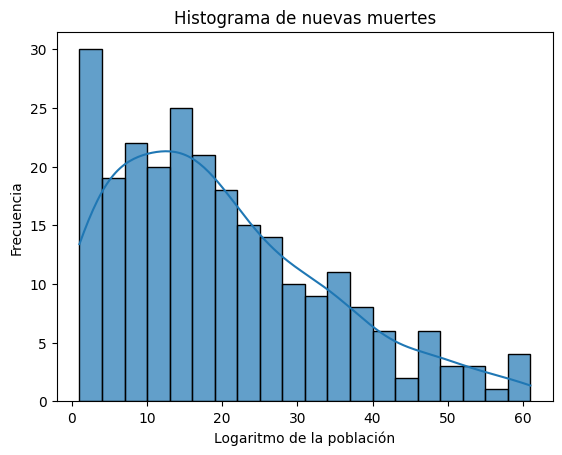

In [42]:
# Filtra los valores mayores que cero
filtered_data = df_country_deaths['new_deaths'][df_country_deaths['new_deaths'] > 0]

# Crea el histograma con la transformación logarítmica
sns.histplot(filtered_data, bins=20, kde=True, edgecolor='black', alpha=0.7)
plt.xlabel('Logaritmo de la población')
plt.ylabel('Frecuencia')
plt.title('Histograma de nuevas muertes')
plt.show()

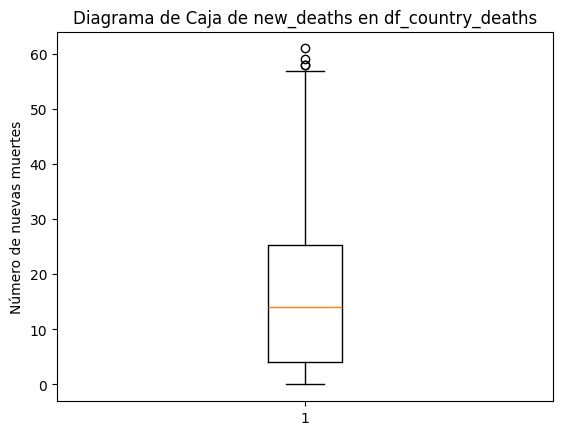

In [43]:
plt.boxplot(df_country_deaths['new_deaths'])

plt.title('Diagrama de Caja de new_deaths en df_country_deaths')
plt.ylabel('Número de nuevas muertes')
plt.show()

### Análisis de Cantidad de Muertes Acumuladas

In [44]:
# Estadísticas Descriptivas
describe = df_country_deaths['cumulative_deaths'].describe()
print(f"Estadísticas descriptivas\n{describe}\n")

# Estadísticas de Conteo
count = df_country_deaths['cumulative_deaths'].count()
print(f"Estadísticas de Conteo\n{count}\n")

# Valores únicos
unique = df_country_deaths['cumulative_deaths'].nunique()
print(f"Valores Únicos\n{unique}\n")

# Promedio
mean = df_country_deaths['cumulative_deaths'].mean()
print(f"Promedio\n{mean}\n")

# Cuartiles
# Mediana (50%)
median_new_deaths = df_country_deaths['cumulative_deaths'].median()

# Cuartiles (25%, 75%)
q1_new_deaths = df_country_deaths['cumulative_deaths'].quantile(0.25)
q3_new_deaths = df_country_deaths['cumulative_deaths'].quantile(0.75)

print("\nMediana para 'cumulative_deaths':", median_new_deaths)
print("\nCuartil 25% para 'cumulative_deaths':", q1_new_deaths)
print("\nCuartil 75% para 'cumulative_deaths':", q3_new_deaths)

Estadísticas descriptivas
count     288.000000
mean     2017.288194
std      1669.618975
min         0.000000
25%        77.000000
50%      2204.000000
75%      3542.250000
max      4803.000000
Name: cumulative_deaths, dtype: float64

Estadísticas de Conteo
288

Valores Únicos
249

Promedio
2017.2881944444443


Mediana para 'cumulative_deaths': 2204.0

Cuartil 25% para 'cumulative_deaths': 77.0

Cuartil 75% para 'cumulative_deaths': 3542.25


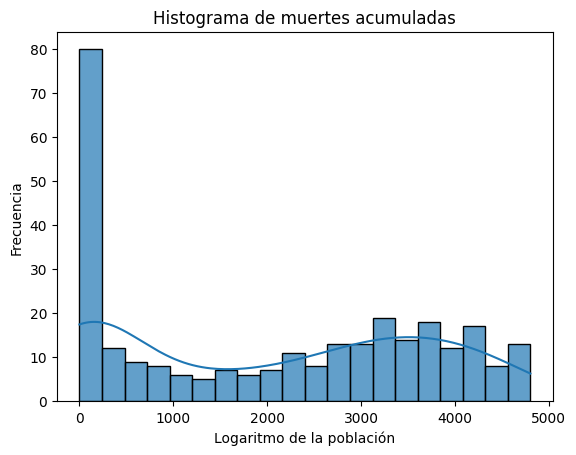

In [45]:
# Filtra los valores mayores que cero
filtered_data = df_country_deaths['cumulative_deaths'][df_country_deaths['cumulative_deaths'] > 0]

# Crea el histograma con la transformación logarítmica
sns.histplot(filtered_data, bins=20, kde=True, edgecolor='black', alpha=0.7)
plt.xlabel('Logaritmo de la población')
plt.ylabel('Frecuencia')
plt.title('Histograma de muertes acumuladas')
plt.show()

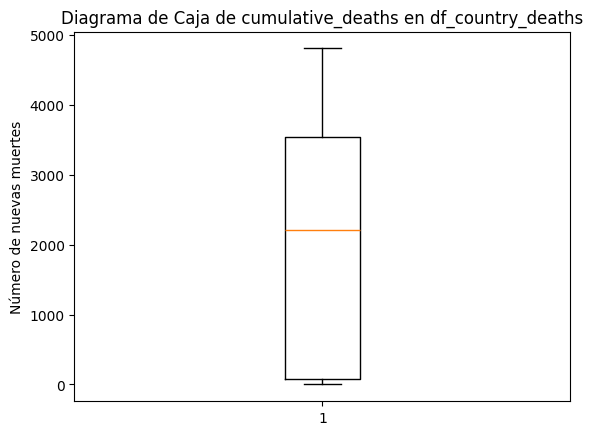

In [46]:
plt.boxplot(df_country_deaths['cumulative_deaths'])

plt.title('Diagrama de Caja de cumulative_deaths en df_country_deaths')
plt.ylabel('Número de nuevas muertes')
plt.show()

### Análisis de Población en los Municipios

In [47]:
# Estadísticas Descriptivas
describe = df_municipality['population'].describe()
print(f"Estadísticas descriptivas\n{describe}\n")

# Estadísticas de Conteo
count = df_municipality['population'].count()
print(f"Estadísticas de Conteo\n{count}\n")

# Valores únicos
unique = df_municipality['population'].nunique()
print(f"Valores Únicos\n{unique}\n")

# Promedio
mean = df_municipality['population'].mean()
print(f"Promedio\n{mean}\n")

# Cuartiles
# Mediana (50%)
median_new_deaths = df_municipality['population'].median()

# Cuartiles (25%, 75%)
q1_new_deaths = df_municipality['population'].quantile(0.25)
q3_new_deaths = df_municipality['population'].quantile(0.75)

print("\nMediana para 'cumulative_deaths':", median_new_deaths)
print("\nCuartil 25% para 'cumulative_deaths':", q1_new_deaths)
print("\nCuartil 75% para 'cumulative_deaths':", q3_new_deaths)

Estadísticas descriptivas
count    3.370000e+02
mean     4.997144e+04
std      8.158246e+04
min      2.563000e+03
25%      1.746500e+04
50%      3.091200e+04
75%      5.852600e+04
max      1.205668e+06
Name: population, dtype: float64

Estadísticas de Conteo
337

Valores Únicos
336

Promedio
49971.44213649852


Mediana para 'cumulative_deaths': 30912.0

Cuartil 25% para 'cumulative_deaths': 17465.0

Cuartil 75% para 'cumulative_deaths': 58526.0


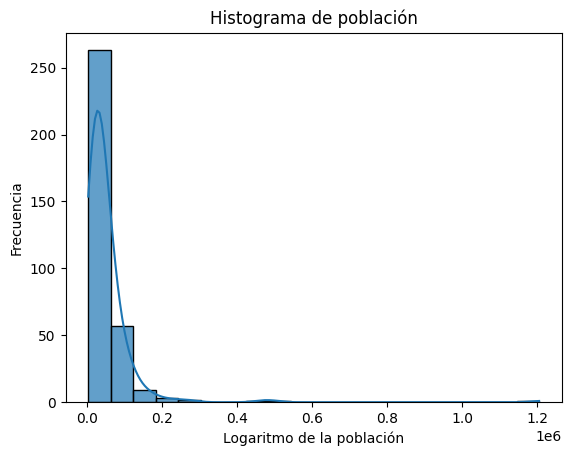

In [48]:
filtered_data = df_municipality['population'][df_municipality['population'] > 0]

# Crea el histograma con la transformación logarítmica
sns.histplot(filtered_data, bins=20, kde=True, edgecolor='black', alpha=0.7)
plt.xlabel('Logaritmo de la población')
plt.ylabel('Frecuencia')
plt.title('Histograma de población')
plt.show()

- El diagrama posee un sesgo, por lo cuál, se hará una transformación logarítmica

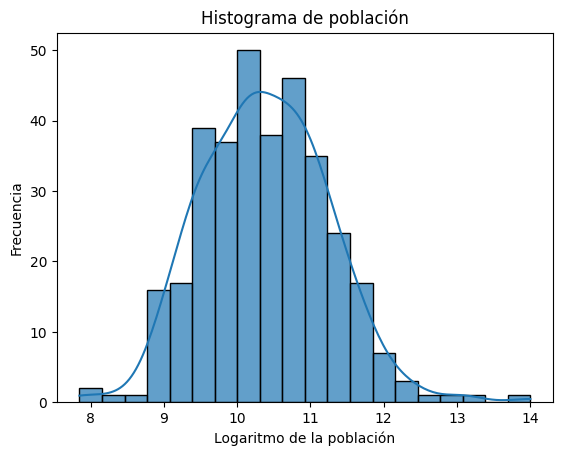

In [49]:
# Filtra los valores mayores que cero
filtered_data = df_municipality['population'][df_municipality['population'] > 0]

# Crea el histograma con la transformación logarítmica
sns.histplot(np.log(filtered_data), bins=20, kde=True, edgecolor='black', alpha=0.7)
plt.xlabel('Logaritmo de la población')
plt.ylabel('Frecuencia')
plt.title('Histograma de población')
plt.show()

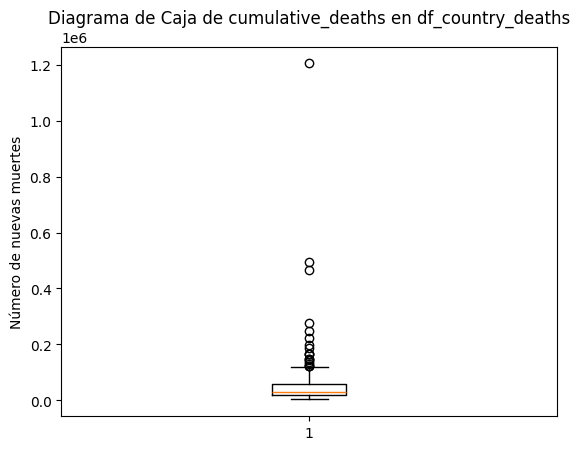

In [50]:
plt.boxplot(df_municipality['population'])

plt.title('Diagrama de Caja de cumulative_deaths en df_country_deaths')
plt.ylabel('Número de nuevas muertes')
plt.show()

### Diagramas de Barras para Variables cualitativas

## EDA Multivariable

### Gráficas de Dispersión

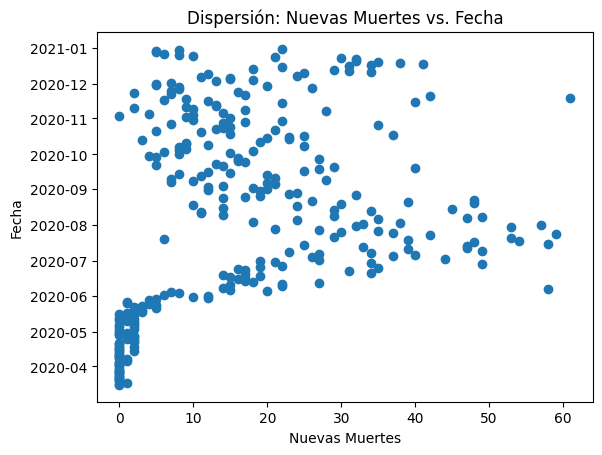

In [51]:
plt.scatter(df_country_deaths['new_deaths'], df_country_deaths['date'])
plt.xlabel('Nuevas Muertes')
plt.ylabel('Fecha')
plt.title('Dispersión: Nuevas Muertes vs. Fecha')
plt.show()

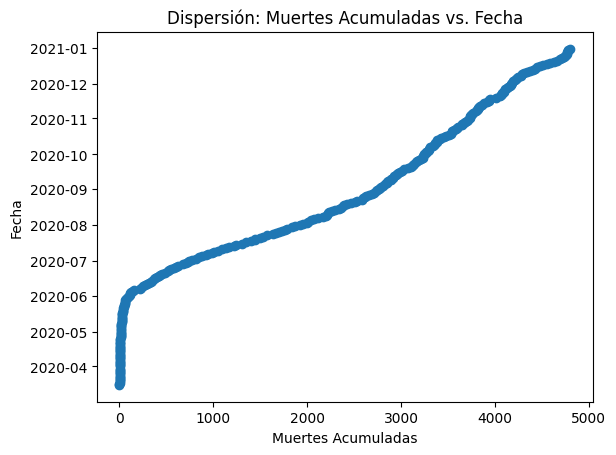

In [52]:
plt.scatter(df_country_deaths['cumulative_deaths'], df_country_deaths['date'])
plt.xlabel('Muertes Acumuladas')
plt.ylabel('Fecha')
plt.title('Dispersión: Muertes Acumuladas vs. Fecha')
plt.show()

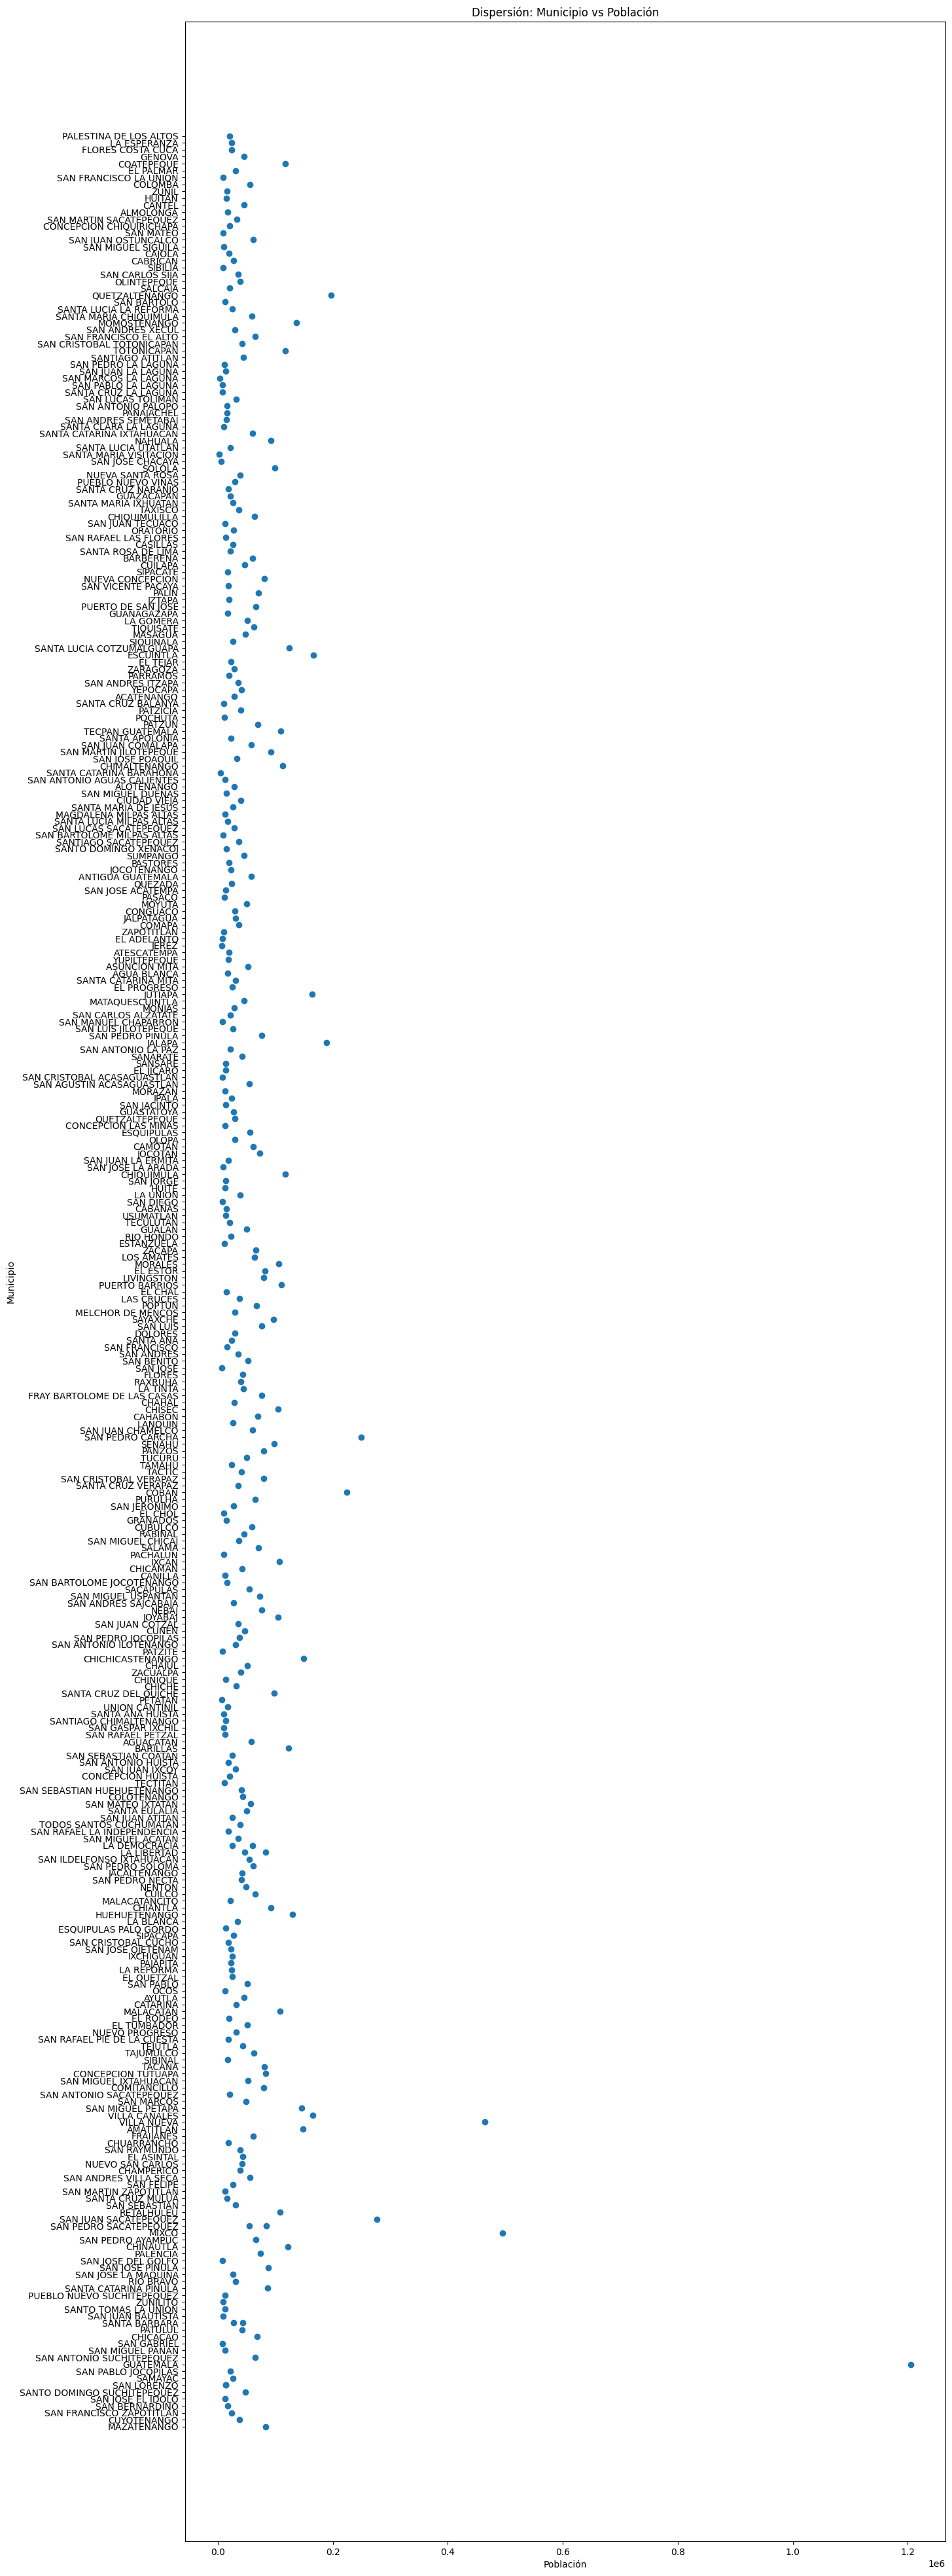

In [53]:
plt.figure(figsize=(15, 50))
plt.scatter(df_municipality['population'], df_municipality['name'])
plt.xlabel('Población')
plt.ylabel('Municipio')
plt.title('Dispersión: Municipio vs Población')
plt.show()

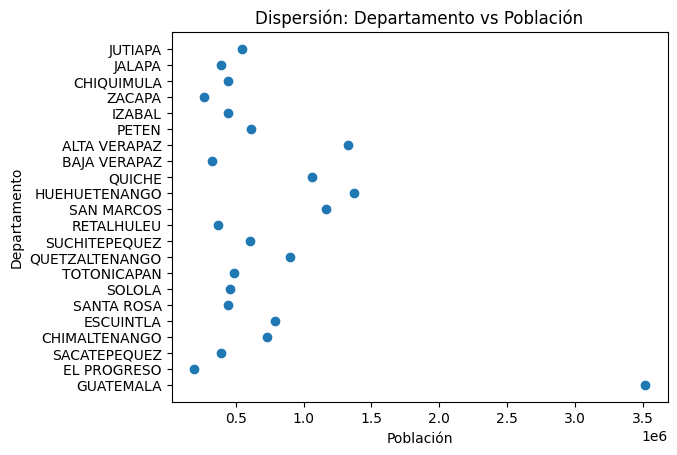

In [54]:
plt.scatter(df_department_population['TotalPopulation'], df_department_population['DepartmentName'])
plt.xlabel('Población')
plt.ylabel('Departamento')
plt.title('Dispersión: Departamento vs Población')
plt.show()

### Gráficas de Barras

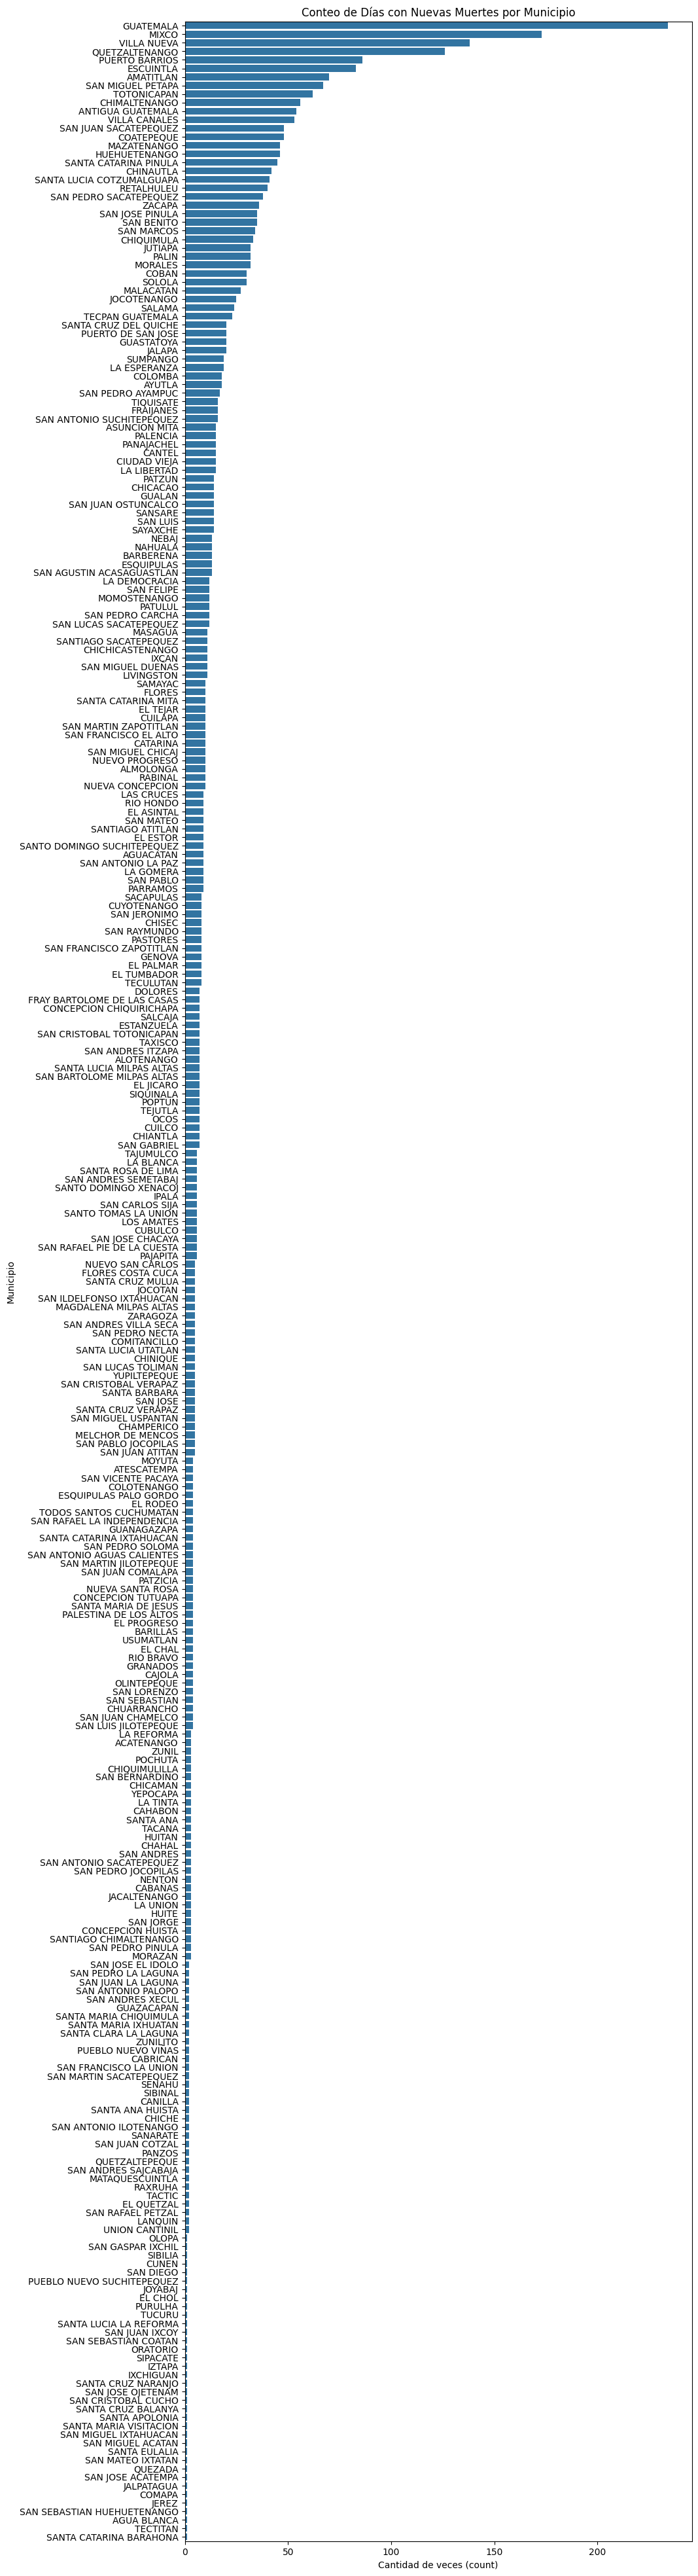

In [57]:
# Filtrar las filas donde total_deaths no es igual a cero
df_filtered = df_municipality_deaths[df_municipality_deaths['total_deaths'] != 0]

# Contar las ocurrencias de cada "name" en el DataFrame filtrado
df_municipality_count = df_filtered['municipality_name'].value_counts().reset_index()
df_municipality_count.columns = ['municipality_name', 'count']

# Crear una gráfica de barras con seaborn
plt.figure(figsize=(10, 50))  # Ajusta el tamaño de la figura según tus necesidades
sns.barplot(x='count', y='municipality_name', data=df_municipality_count)  # Muestra las 10 primeras para legibilidad

# Añadir etiquetas y título
plt.xlabel('Cantidad de veces (count)')
plt.ylabel('Municipio')
plt.title('Conteo de Días con Nuevas Muertes por Municipio')

# Mostrar el gráfico
plt.show()

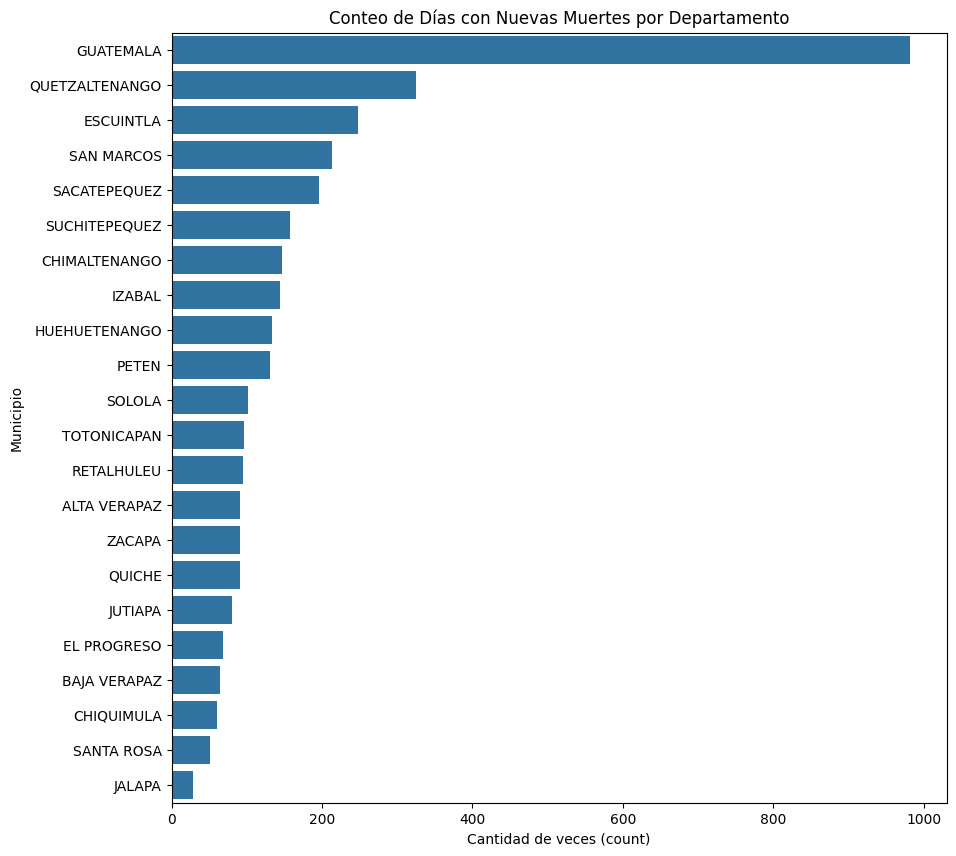

In [61]:
df_filtered = df_municipality_deaths[df_municipality_deaths['total_deaths'] != 0]

# Contar las ocurrencias de cada "name" en el DataFrame filtrado
df_municipality_count = df_filtered['department_name'].value_counts().reset_index()
df_municipality_count.columns = ['department_name', 'count']

# Crear una gráfica de barras con seaborn
plt.figure(figsize=(10, 10))  # Ajusta el tamaño de la figura según tus necesidades
sns.barplot(x='count', y='department_name', data=df_municipality_count)  # Muestra las 10 primeras para legibilidad

# Añadir etiquetas y título
plt.xlabel('Cantidad de veces (count)')
plt.ylabel('Municipio')
plt.title('Conteo de Días con Nuevas Muertes por Departamento')

# Mostrar el gráfico
plt.show()

In [ ]:
# Crear una gráfica de barras con seaborn
plt.figure(figsize=(10, 10))  # Ajusta el tamaño de la figura según tus necesidades
sns.barplot(x='population', y='name', data=df_municipality)  # Muestra las 10 primeras para legibilidad

# Añadir etiquetas y título
plt.xlabel('Cantidad de veces (count)')
plt.ylabel('Municipio')
plt.title('Conteo de Días con Nuevas Muertes por Departamento')

# Mostrar el gráfico
plt.show()

### Mapas de Calor